## Creación de modelo de predicción de energía eléctrica en Sklearn e implementación en SageMaker

## 1. CARGUE DE DATOS

In [1]:
# Cargue de librerias
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker
from datetime import datetime

In [3]:
# Se utilizará la serie de tiempo subida a S3

path = "s3://timeserie0112/Datos/ts_load_train.csv"

In [6]:
# Cargue de datos
ts = pd.read_csv(path, 
                squeeze=True,
                index_col=0,
                parse_dates=True)

In [8]:
ts.shape

(50376,)

## 2. DIVISIÓN DE DATOS

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ts, test_size=0.1, shuffle=False)

## 3. GRÁFICA DE LOS DATOS

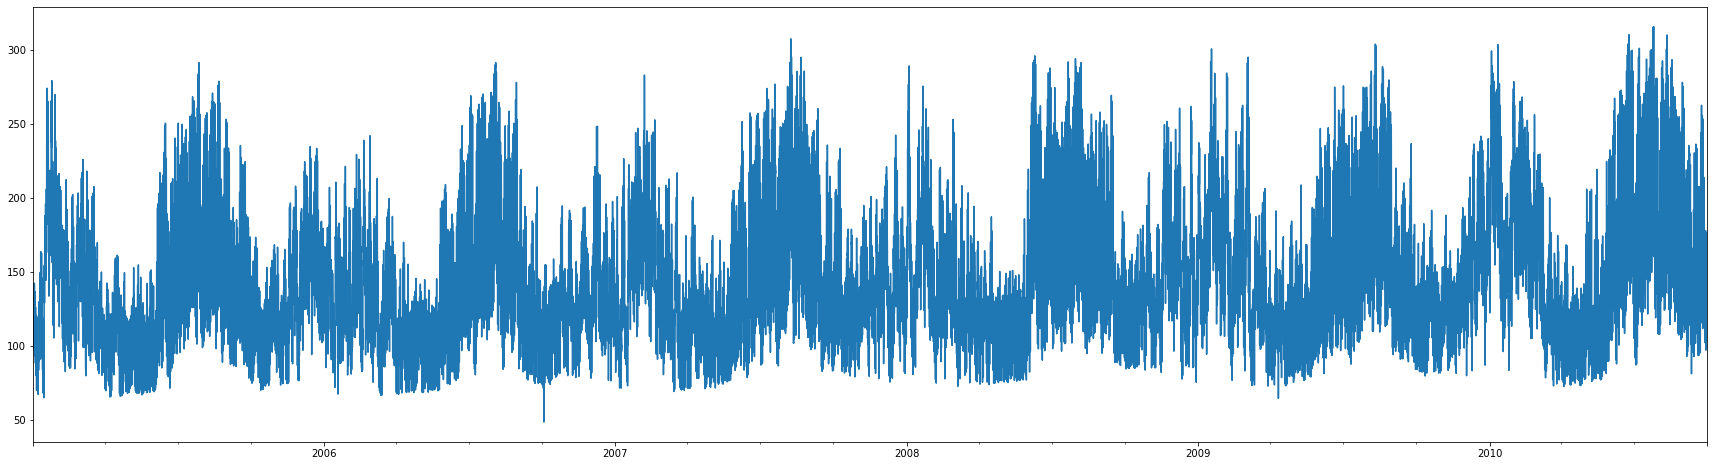

In [10]:
from matplotlib import rcParams
# Gráfica de la serie train
rcParams["figure.figsize"] = [30,8]
ts.plot()
plt.show()

## 4. CREACIÓN DE ATRASOS COMO VARIABLES DE PREDICCION

In [11]:
# Se crean 4 atrasos

df = pd.DataFrame()
nlags = 4
for i in range(nlags):
  df[f't-{i}'] = train.shift(i)


df = df.dropna(axis=0)
df.head()

,t-0,t-1,t-2,t-3
2005-01-01 04:00:00,114.4,117.0,121.8,125.8
2005-01-01 05:00:00,113.6,114.4,117.0,121.8
2005-01-01 06:00:00,116.1,113.6,114.4,117.0
2005-01-01 07:00:00,121.0,116.1,113.6,114.4
2005-01-01 08:00:00,127.8,121.0,116.1,113.6


## 5. CREACIÓN DEL  MODELO

In [13]:
# Se crean las variables del modelo

X = df[["t-1", "t-2", "t-3"]].to_numpy()
y = df["t-0"].to_numpy()

In [45]:
X

array([[117. , 121.8, 125.8],
       [114.4, 117. , 121.8],
       [113.6, 114.4, 117. ],
       ...,
       [182.2, 189.7, 190.4],
       [174.7, 182.2, 189.7],
       [170.9, 174.7, 182.2]])

In [26]:
from sklearn.linear_model import LinearRegression

clf =  LinearRegression(fit_intercept=False)
clf.fit(X, y)

LinearRegression(fit_intercept=False)

In [27]:
y_pred = pd.Series(clf.predict(X), index=df.index)

In [67]:
clf.predict(x_in)

array([113.05155635, 113.08960163])

In [64]:
y_pred

2005-01-01 04:00:00    113.051556
2005-01-01 05:00:00    113.089602
2005-01-01 06:00:00    113.400703
2005-01-01 07:00:00    118.743907
2005-01-01 08:00:00    124.975564
                          ...    
2010-03-04 22:00:00    190.651619
2010-03-04 23:00:00    186.334748
2010-03-05 00:00:00    174.002749
2010-03-05 01:00:00    169.009029
2010-03-05 02:00:00    169.152250
Length: 45335, dtype: float64

In [65]:
X

array([[117. , 121.8, 125.8],
       [114.4, 117. , 121.8],
       [113.6, 114.4, 117. ],
       ...,
       [182.2, 189.7, 190.4],
       [174.7, 182.2, 189.7],
       [170.9, 174.7, 182.2]])

In [66]:
x_in = np.array([[117. , 121.8, 125.8],
       [114.4, 117. , 121.8]])

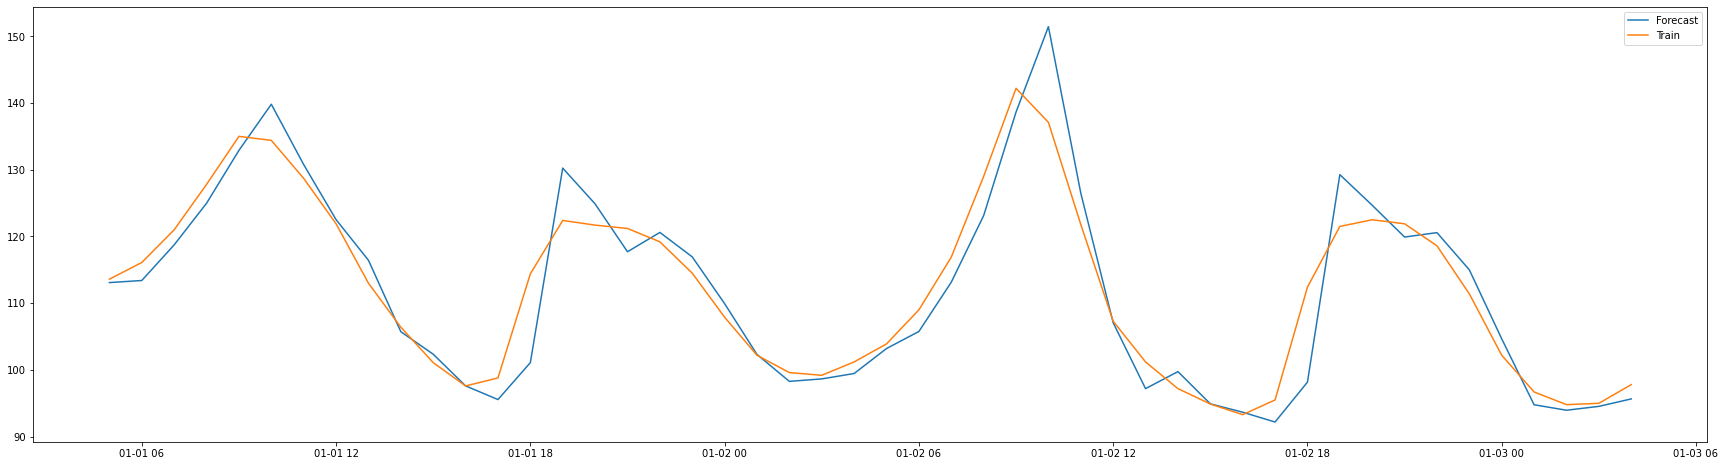

In [28]:
# Verificación del pronóstico
rcParams["figure.figsize"] = [30,8]
plt.plot(y_pred[1:49], label="Forecast")
plt.plot(df["t-0"][1:49], label="Train")
plt.legend()
plt.show()

In [23]:
# Metricas del modelo sobre los datos de entrenamiento

In [29]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from math import sqrt

# Metricas de error
mse_train = mse(y, y_pred)
rmse_train = sqrt(mse_train)
mape_train = mape(y, y_pred)
print (f"MSE Train: {mse_train}")
print (f"RMSE Train: {rmse_train}")
print (f"MAPE Train: {mape_train}")

MSE Train: 36.335768165382014
RMSE Train: 6.0279157397380745
MAPE Train: 0.02901882087104711


## EXPORTACION DEL MODELO

In [30]:
joblib.dump(clf, "model.joblib")

['model.joblib']

Como ya se tiene el modelo se debe generar un archivo comprimido tar.gz para llevarlo a S3 y que de allí pueda ser utilizado por SageMaker

In [31]:
# Se procede a crear el archivo tar.gz
!tar -zcvf model.tar.gz model.joblib

model.joblib


## DESPLIEGUE DEL MODELO

In [5]:
# Se crea una session de sagemaker
session = sagemaker.Session()

In [6]:
# Se procede a cargar el archivo en S3, para lo cual hay que indicar el 
#nombre del bucket, nombre de la carpeta y el nombre del archivo
# también se procede a guardar la ruta en una variable

s3_uri_model = session.upload_data(bucket="timeserie0112", 
                                   key_prefix="Model", 
                                   path="model.tar.gz")

In [7]:
# Se procede a verificar la ruta del archivo cargado
s3_uri_model

's3://timeserie0112/Model/model.tar.gz'

In [8]:
# Ya que se necesita una imagen de sklearn para desplegar el modelo
# importamos la librería 
from sagemaker.sklearn import SKLearnModel

Creamos el archivo entry_point.py para concatenar la ruta del archivo, cargar el modelo y utilizarlo como entrypoint

In [9]:
%%writefile entry_point.py
import joblib
import os
def model_fn(model_path):
    return joblib.load(os.path.join(model_path, "model.joblib"))

Overwriting entry_point.py


In [10]:
# Se crea el modelo en sagemaker para el despliegue

model = SKLearnModel(entry_point="entry_point.py", 
                     role="LabRole", 
                     framework_version="1.0-1", # Se expecifica la version de sklearn
                     model_data=s3_uri_model)

In [11]:
# Se procede a realizar el despliegue, hay que indicar el
# tipo de instancia en que se quiere desplegar el modelo

predictor = model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")

-----!

In [12]:
# le debemos indicar que el archivo es CSV

from sagemaker.serializers import CSVSerializer
predictor.serializer = CSVSerializer()

Se realiza una predicción, para lo cual se indican los datos de entrada

In [61]:
x_in = np.array([[117,121,125], [120,121,122]])

print(x_in)

[[117 121 125]
 [120 121 122]]


In [62]:
predictor.predict(x_in)

array([113.90197773, 118.9861603 ])